In [11]:
from Bio import SeqIO
import pysam
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## First task

С помощью колдовства и pileup() могу вывести покрытие для каждой позиции нуклеотида

In [41]:
for read in SeqIO.parse('/home/beleckiy/ngs/E.coli/MG1655-K12.fasta', 'fasta'):
    gn = read.seq

In [2]:
sam_file = pysam.AlignmentFile('sorted_alignment.bam', 'rb')

In [3]:
pileups = []
for pileupcolumn in sam_file.pileup():
    pileups.append(pileupcolumn.n)
    

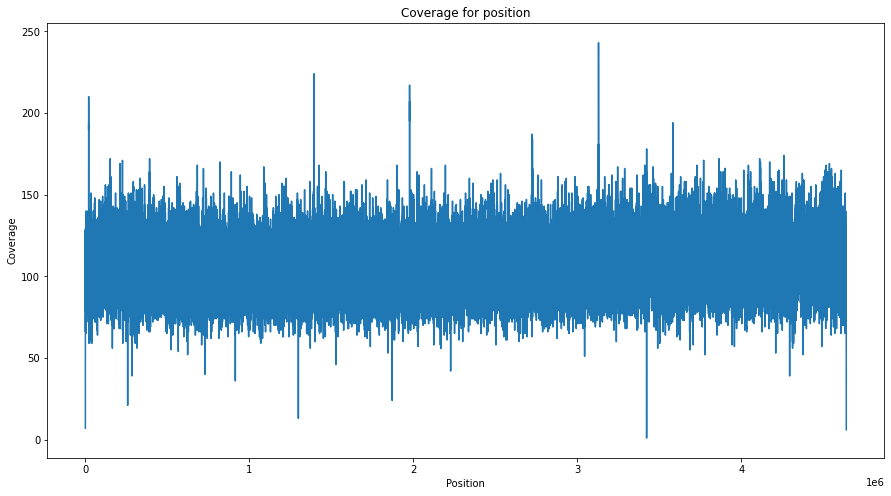

In [36]:
plt.figure(figsize=(15, 8))
plt.plot(pileups)
plt.ylabel('Coverage')
plt.xlabel('Position')
plt.title('Coverage for position')
None

Долю покрытой области генома можем посчитать как

In [45]:
len([i for i in pileups if i != 0]) / len(gn)

1.0

Чтобы чуть уменьшить разброс и чуть лучше рассмотреть тренд, для этого:

Рассматриваю участки генома по 1000, считаю отношение покрытие для каждого такого маленького участочка 

In [14]:
ready = 0
aver = []
while ready < len(pileups):
    aver.append(sum(pileups[ready:ready + 1000]) / 1000)
    ready += 1000

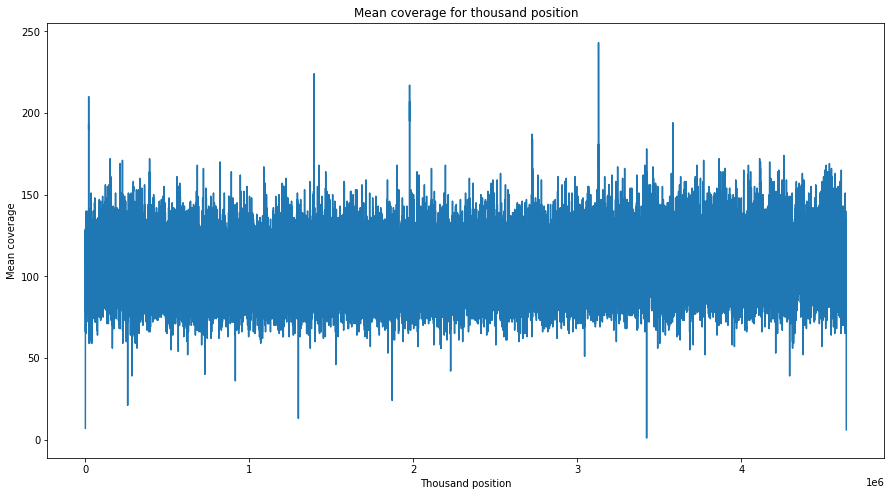

In [37]:
plt.figure(figsize=(15, 8))
plt.plot(pileups)
plt.ylabel('Mean coverage')
plt.xlabel('Thousand position')
plt.title('Mean coverage for thousand position')
None

На графике выше уже чуть лучше видно общий тренд, хотя разброс всё ещё довольно велик В среднем, большая часть нуклеотидов собирается у покрытия равное стам

## Task 2

In [61]:
sam_file = pysam.AlignmentFile('alignment.sam', 'rb')

In [62]:
tlen = []

C помощью template_length можем получить расстояние вставки, отфильтруем серьёзные выбросы(>1000) и overlaps(< 0)

In [63]:
for nucl in sam_file:
        if nucl.template_length > 0 and nucl.template_length < 1000:
            tlen.append(nucl.template_length)

In [65]:
np.mean(tlen)

215.37719430940848

In [59]:
np.mean(tlen)

0.0

Text(0.5, 1.0, 'Insertion size count')

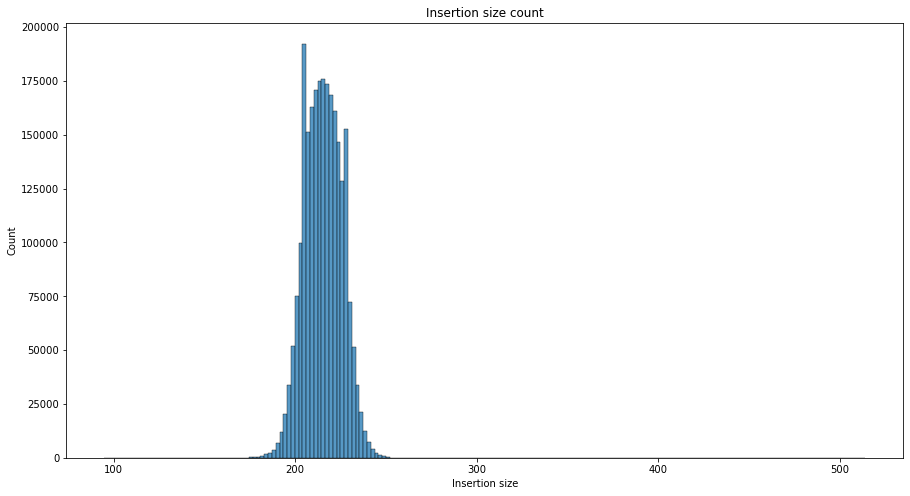

In [88]:
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.histplot(tlen, bins=200)
plt.xlabel('Insertion size')
plt.title('Insertion size count')

Видим, что распределение расстояния вставки -- нормально, большая часть ридов сосредоточена около расстояния равного 215

In [86]:
print('mean:', np.mean(tlen))
print('standart deviation:', np.std(tlen))
print('interval for 95 % reads:', np.quantile(tlen,q=0.95))

mean: 215.37719430940848
standart deviation: 10.662511919098636
interval for 95 % reads: 232.0


Следовательно, почти все риды (95 %) имеют расстояние вставки не более 232

## Task 3

Заводим словарь словарей и идём по ридам.
С помощью метода get_aligned_pairs() мы получаем пары, где первый элемент -- позиция нуклеотида в риде, а вторая -- в референсе

Если нуклеотид равен N или None, то считаем как '-'

In [47]:
sam_file = pysam.AlignmentFile('sorted_alignment.bam', 'rb')
d = {
    'A': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '-': 0},
    'C': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '-': 0},
    'G': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '-': 0},
    'T': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '-': 0},
    '-': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '-': 0}
}

In [48]:
index = 0
for read in sam_file:
    for nucl in read.get_aligned_pairs():
        if None in nucl:
            if nucl[0] is None and nucl[1] is not None:
                if gn[nucl[1]] != 'N':
                    d['-'][gn[nucl[1]]] += 1
            elif nucl[1] is None and nucl[0] is not None:
                if read.seq[nucl[0]] != 'N':
                    d[read.seq[nucl[0]]]['-'] += 1
        elif gn[nucl[1]] == 'N' and read.seq[nucl[0]] != 'N':
            d[read.seq[nucl[0]]]['-'] += 1
        elif gn[nucl[1]] != 'N' and read.seq[nucl[0]] == 'N':
            d['-'][gn[nucl[1]]] += 1
        else:
            d[read.seq[nucl[0]]][gn[nucl[1]]] += 1
                

Зануляем главную диагональ

In [51]:
for key in d.keys():
    for value in d[key].keys():
        if value == key:
            d[key][value] = 0

In [68]:
import pandas as pd

In [12]:
pd.DataFrame(d)

,A,C,G,T,-
A,0,1103106,757057,328867,83289
C,547886,0,630877,350930,83811
G,356067,630990,0,548661,84034
T,330422,752650,1100735,0,82987
-,4326,8949,8833,4328,0


In [15]:
d_df = pd.DataFrame(d)

## Общее количество ридов

Для того, чтобы посчитать средний процент ошибок считаем общее количество ридов

In [22]:
sam_file = pysam.AlignmentFile('sorted_alignment.bam', 'rb')
read_len = 0
for nucl in sam_file:
    read_len += len(nucl.seq)

Считаем общее количество ошибок

In [26]:
error_sum = d_df.iloc[0:4, 0:4].sum().sum()

Средний процент ошибок

In [28]:
error_sum / read_len * 100

1.4876496

Средний процент ошибки составляет всего лишь 1.5 %, что, в целом, является допустимым показателем для секвенирования технологией Illumina